In [1]:
# Dependencies
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
import cv2 as cv


# Own Dependencies
from lib.Visualize import visualize_points_and_circle,show_images
from lib.RANSAC import Ransac,Circle

### $Q_1$ : Circle Fitting

In [48]:

# Points Generation
N = 100
half_n = N//2

R = 10
s = R/16
t = np.random.uniform(0, 2*np.pi ,half_n)
n = s*np.random.randn(half_n)

x ,y = (R + n)*np.cos(t), (R + n)*np.sin(t)

X_circ = np.hstack((x.reshape(half_n , 1), y.reshape(half_n, 1)))

m, b = -1, 2
x = np.linspace(-12, 12, half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))

X = np.vstack((X_circ, X_line))

In [57]:
# Using Ransac to get the model
threshold = 1
ransac_run = Ransac(X,threshold)
circle,model_points = ransac_run.get_model()
inliers,outliers = ransac_run.get_inliers_outliers()
print(ransac_run)

# Getting Final Model using found Inliers
final_model = Circle.randy_bullock_fit(inliers)


Model Parameters :  X=-0.023649 Y=-0.857552 R=10.150337
Number of Samples = 100 
 Iterations Done = 25
 Inliers Count : 51


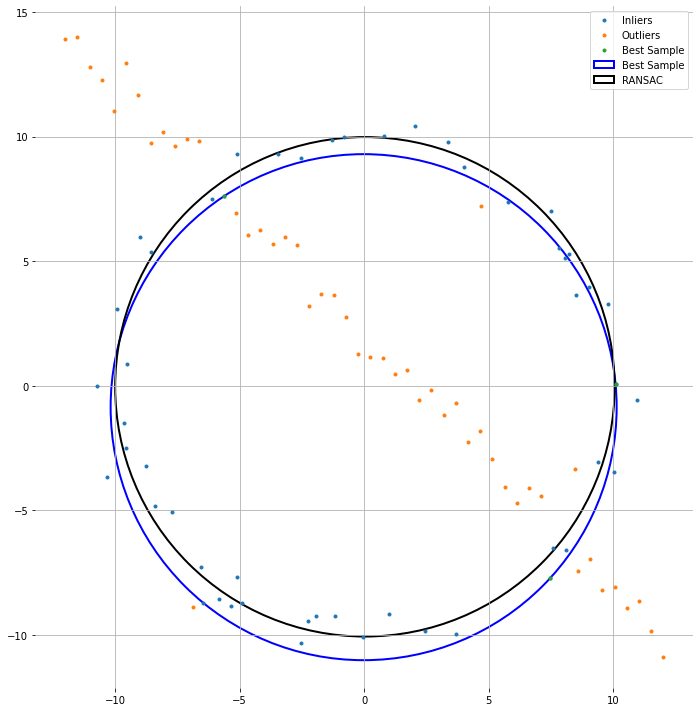

In [58]:

visualize_points_and_circle([inliers,outliers,model_points],[[circle,'blue'],[final_model,'black']],legends=[["Inliers",'Outliers',"Best Sample"],['Best Sample','RANSAC']],grid=True)

### $Q_2$ : Super Impose Image

In [6]:
# Function to create overlay
def overlay_image(im_src,im_dst,pts_src,pts_dst):
    h = cv.getPerspectiveTransform(pts_src, pts_dst)
    transformed_image=cv.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0]))
    b = (transformed_image[:,:,0]==0)*im_dst[:,:,0]
    g=(transformed_image[:,:,1]==0)*im_dst[:,:,1]
    r=(transformed_image[:,:,2]==0)*im_dst[:,:,2]
    masked=np.dstack((b,g,r))
    overlayed=cv.add(masked,transformed_image)
    return overlayed

# Importing Images
ice_age = cv.imread(r'./images/ice-age.webp')
virumandi = cv.imread(r'./images/virumandi.jpg')
image = cv.imread(r'./images/times_square_night.jpg')
assert ice_age is not None
assert virumandi is not None
assert image is not None

In [ ]:
# Function for getting co-ordinates by mouse click
def click_event(event,x,y,flags,params):
    if event==cv.EVENT_LBUTTONDOWN:
        print(x,' ',y)
        

cv.imshow('image',image)
cv.setMouseCallback('image',click_event)
cv.waitKey(0)
cv.destroyAllWindows()

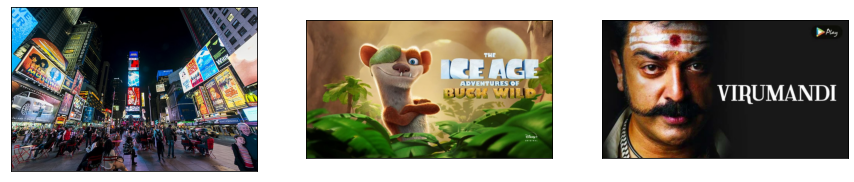

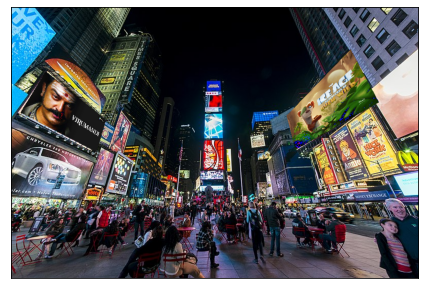

In [65]:
# Defining Points to find homography
iceAge_src = np.float32([[0, 0], [ice_age.shape[0], 0], [ice_age.shape[0], ice_age.shape[1]], [0, ice_age.shape[1]]])
ice_age_dst = np.float32([[540, 215], [593,160],[653,327],[573,344]])

virumandi_src = np.float32([[0, 0], [virumandi.shape[0], 0], [virumandi.shape[0], virumandi.shape[1]], [0, virumandi.shape[1]]])
virumandi_dst = np.float32([[68,128], [145,190],[90,330],[-35,295]])

final1 = overlay_image(ice_age,image,iceAge_src,ice_age_dst)
final2 = overlay_image(virumandi,final1,virumandi_src,virumandi_dst)
show_images([[image],[ice_age],[virumandi]],size=5)
show_images([[final2]],size=20)